In [1]:
from functools import partial
from pathlib import Path

import numpy as np
import torch.nn as nn
from rl_zoo3 import linear_schedule
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from wandb.integration.sb3 import WandbCallback

import wandb
from src.eval import Episode, Study
from src.eval.eval_rl_v3_sim import evaluate_policy
from src.train.ea_ppo import make_env
from src.utils import load_config, save_config

In [2]:
config = {
    # Environment
    "action_mode": "delta",
    "max_quad_setting": 30.0,
    "max_quad_delta": 30.0,
    "max_steerer_delta": 6.1782e-3,
    "magnet_init_mode": np.array([10.0, -10.0, 0.0, 10.0, 0.0]),
    "incoming_mode": "random",
    "misalignment_mode": "random",
    "max_misalignment": 5e-4,
    "simulate_finite_screen": False,
    "target_beam_mode": np.zeros(4),
    "threshold_hold": 1,
    "clip_magnets": True,
    # Wrappers
    "frame_stack": 1,  # 1 means no frame stacking
    "normalize_observation": True,
    "rescale_action": True,
    "target_threshold": None,  # 2e-5 m is estimated screen resolution
    "max_episode_steps": 50,
    # RL algorithm
    "batch_size": 64,
    "learning_rate": 0.0003,
    "lr_schedule": "constant",  # Can be "constant" or "linear"
    "gamma": 0.99,
    "n_envs": 40,
    "n_steps": 64,
    "ent_coef": 0.0,
    "n_epochs": 10,
    "gae_lambda": 0.95,
    "clip_range": 0.2,
    "clip_range_vf": None,  # None,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "use_sde": False,
    "sde_sample_freq": -1,
    "target_kl": None,
    "total_timesteps": 500_000,
    # Policy
    "net_arch": "small",  # Can be "small" or "medium"
    "activation_fn": "Tanh",  # Tanh, ReLU, GELU
    "ortho_init": True,  # True, False
    "log_std_init": 0.0,
    # SB3 config
    "sb3_device": "auto",
    "vec_env": "subproc",
}

In [3]:
# Setup wandb
wandb.init(
    entity="msk-ipc",
    project="rl4aa-tutorial-2025-dev",
    sync_tensorboard=True,
    monitor_gym=True,
    config=config,
    dir=".wandb",
)
config = dict(wandb.config)
config["run_name"] = wandb.run.name

# Setup vecorised environments for training and evaluation
assert config["vec_env"] in ["dummy", "subproc"]
vec_env = (
    DummyVecEnv([partial(make_env, config) for _ in range(config["n_envs"])])
    if config["vec_env"] == "dummy"
    else SubprocVecEnv([partial(make_env, config) for _ in range(config["n_envs"])])
)
eval_vec_env = DummyVecEnv(
    [partial(make_env, config, plot_episode=True, log_task_statistics=True)]
)


# Setup learning rate schedule if needed
if config["lr_schedule"] == "linear":
    config["learning_rate"] = linear_schedule(config["learning_rate"])

# Setup RL training algorithm
model = PPO(
    "MlpPolicy",
    vec_env,
    learning_rate=config["learning_rate"],
    n_steps=config["n_steps"],
    batch_size=config["batch_size"],
    n_epochs=config["n_epochs"],
    gamma=config["gamma"],
    gae_lambda=config["gae_lambda"],
    clip_range=config["clip_range"],
    clip_range_vf=config["clip_range_vf"],
    ent_coef=config["ent_coef"],
    vf_coef=config["vf_coef"],
    max_grad_norm=config["max_grad_norm"],
    use_sde=config["use_sde"],
    sde_sample_freq=config["sde_sample_freq"],
    target_kl=config["target_kl"],
    policy_kwargs={
        "activation_fn": getattr(nn, config["activation_fn"]),
        "net_arch": {  # From rl_zoo3
            "small": {"pi": [64, 64], "vf": [64, 64]},
            "medium": {"pi": [256, 256], "vf": [256, 256]},
        }[config["net_arch"]],
        "ortho_init": config["ortho_init"],
        "log_std_init": config["log_std_init"],
    },
    device=config["sb3_device"],
    tensorboard_log=f"log/{config['run_name']}",
    verbose=1,
)

# Setup callbacks for evaluation and logging
eval_callback = EvalCallback(eval_vec_env, eval_freq=1_000, n_eval_episodes=5)
wandb_callback = WandbCallback()

# Train the model
model.learn(
    total_timesteps=config["total_timesteps"],
    callback=[eval_callback, wandb_callback],
)

# Save the model and associated configuration
model.save(f"models/ea/ppo/{wandb.run.name}/model")
save_config(config, f"models/ea/ppo/{wandb.run.name}/config")

# Cleanup environments
vec_env.close()
eval_vec_env.close()

Using cpu device
Logging to log/dummy-ne39rikw/PPO_1


/opt/homebrew/Caskroom/miniforge/base/envs/rl4aa25-tutorial/lib/python3.12/site-packages/stable_baselines3/common/callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x1646e7530> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x14e3e3d10>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -0.69    |
| time/              |          |
|    fps             | 848      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2560     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | -0.728      |
| time/                   |             |
|    fps                  | 1066        |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 5120        |
| train/                  |             |
|    approx_kl            | 0.009799362 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.12       |
|    explained_variance   | -2.41       |
|    learning_rate        | 0.

/opt/homebrew/Caskroom/miniforge/base/envs/rl4aa25-tutorial/lib/python3.12/site-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path 'models/ea/ppo/dummy-ne39rikw' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")
/Users/jankaiser/Documents/DESY/rl4aa25-tutorial/src/wrappers/plot_episode.py:128: UserWarning: WARN: Unable to save episode plot for self.episode_id = 60 because the episode was too short.
  logger.warn(
/Users/jankaiser/Documents/DESY/rl4aa25-tutorial/src/wrappers/log_task_statistics.py:72: UserWarning: WARN: Unable to save episode plot for self.episode_id = 60 because the episode was too short.
  logger.warn(


In [4]:
model_name = config["run_name"]
model_path = Path("models") / "ea" / "ppo" / model_name
model = PPO.load(model_path / "model")
config = load_config(model_path / "config")

evaluate_policy(model, config, write_data=True)

In [5]:
study = Study.load(f"data/evaluate_policy/{model_name}")

In [6]:
print(f"Final MAE: {study.median_final_mae() * 1e6:.0f} μm")
print(
    f"Steps to convergence: {study.median_steps_to_convergence(threshold=4e-5)}"
)  # Set threshold
print(
    f"Sum of magnet changes: {study.median_sum_of_normalized_magnet_changes():.1f}"
)  # Implement

Final MAE: 1425000 μm
Steps to convergence: 1.0
Sum of magnet changes: 12.2


In [14]:
eval_vec_env.envs[0].unwrapped.backend.segment

Segment(elements=ModuleList(
  (0): Marker(name='AREASOLA1')
  (1): Drift(length=tensor(0.1750), tracking_method='cheetah', name='Drift_AREASOLA1')
  (2): Quadrupole(length=tensor(0.1220), k1=tensor(10.), misalignment=tensor([-0.0005,  0.0003]), tilt=tensor(0.), num_steps=1, tracking_method='cheetah', name='AREAMQZM1')
  (3): Drift(length=tensor(0.4280), tracking_method='cheetah', name='Drift_AREAMQZM1')
  (4): Quadrupole(length=tensor(0.1220), k1=tensor(-10.), misalignment=tensor([-6.5116e-05,  3.1703e-04]), tilt=tensor(0.), num_steps=1, tracking_method='cheetah', name='AREAMQZM2')
  (5): Drift(length=tensor(0.2040), tracking_method='cheetah', name='Drift_AREAMQZM2')
  (6): VerticalCorrector(length=tensor(0.0200), angle=tensor(0.), name='AREAMCVM1')
  (7): Drift(length=tensor(0.2040), tracking_method='cheetah', name='Drift_AREAMCVM1')
  (8): Quadrupole(length=tensor(0.1220), k1=tensor(10.), misalignment=tensor([1.0462e-04, 9.9760e-05]), tilt=tensor(0.), num_steps=1, tracking_method='c

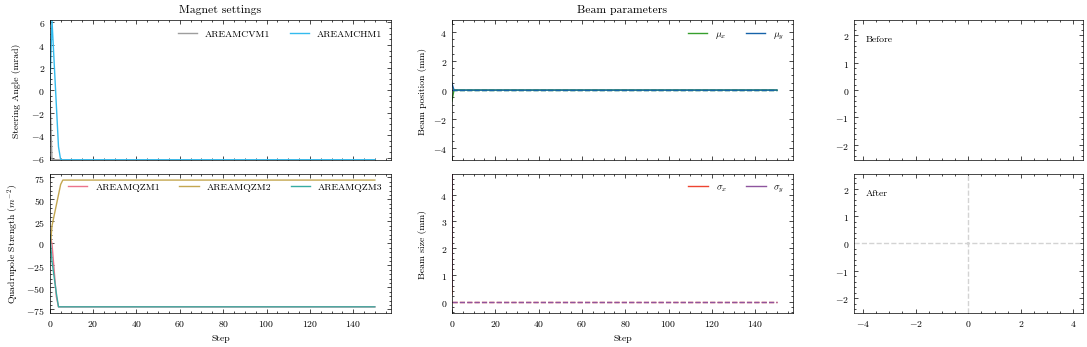

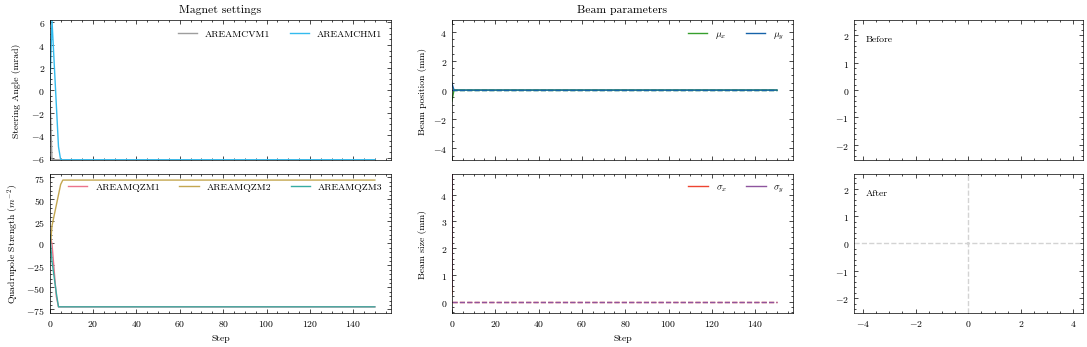

In [7]:
study.episodes[99].plot_summary()